# <font style="font-family:roboto;color:#455e6c"> Parametrising a Machine Learning Interatomic Potential </font>  

<div class="admonition note" name="html-admonition" style="background:#e3f2fd; padding: 10px">
<font style="font-family:roboto;color:#455e6c"> <b> Machine Learning Modalities for Materials Science Workshop, Jožef Stefan Institute, Ljubljana </b> </font> </br>
<font style="font-family:roboto;color:#455e6c"> 14 May 2024 </font>
</div>

In this notebook, the strategies to generate data set are shown. We will then fit an [Atomic Cluster Expansion](https://doi.org/10.1103/PhysRevB.99.014104) interatomic potential using the [pacemaker](https://www.nature.com/articles/s41524-021-00559-9) software.

In [1]:
%config IPCompleter.evaluation='unsafe'

In [2]:
from pyiron import Project
import numpy as np
import matplotlib.pyplot as plt

We start by creating a project

In [5]:
pr = Project('dataset_generation')

In this notebook, we will use the Aluminium as an example, similar to the last notebook. There are many strategies that can be employed to generate datasets, we will look at some of them here.

## <font style="font-family:roboto;color:#455e6c"> Generating bulk structures </font> 

One of the strategies employed is to generate bulk structure of Al which is then fully relaxed, and stored for ML fitting. Here, we will show the example of fcc Al.

In [6]:
Al = pr.create.structure.bulk('Al', cubic=True, a=4.04)

For more details on generating and manipulating structures, please have a look at our [structures example](https://pyiron.readthedocs.io/en/latest/source/notebooks/structures.html). In this section however, we show how to generate and manipulate bulk crystals, surfaces, etc. pyiron's structure class is derived from the popular [`ase` package](https://wiki.fysik.dtu.dk/ase/ase/build/build.html) and any `ase` function to manipulate structures can also be applied here.

Now we have to relax this structure. Ideally, high convergence DFT calculations are needed, eg with VASP or QuantumEspresso. Here we will simply use LAMMPS with an emperical potential to demonstrate the calculations.

In [7]:
job = pr.create.job.Lammps('Al_bulk', delete_aborted_job=True)
job.structure = Al

In [8]:
job.potential = "2005--Mendelev-M-I--Al-Fe--LAMMPS--ipr1"

Now relax the structure

In [9]:
job.calc_minimize(pressure=0)

And run the job

In [10]:
job.run()

The job Al_bulk was saved and received the ID: 381


Another step done to collect structures for fitting is to run a EV curve . We can use the Murnaghan job from pyiron for this. First we set up a LAMMPS job again.

In [11]:
job = pr.create.job.Lammps('Al_bulk', delete_existing_job=True, delete_aborted_job=True)
job.structure = Al
job.potential = "2005--Mendelev-M-I--Al-Fe--LAMMPS--ipr1"
job.calc_minimize()

Now we can create a Murnaghan Job

In [12]:
murn = job.create_job(pr.job_type.Murnaghan, 'murnaghan')

We can check the possible input options

In [13]:
murn.input

,Parameter,Value,Comment
0,num_points,11,number of sample points
1,fit_type,polynomial,"['polynomial', 'birch', 'birchmurnaghan', 'mur..."
2,fit_order,3,order of the fit polynom
3,vol_range,0.1,relative volume variation around volume define...
4,axes,"(x, y, z)",Axes along which the strain will be applied
5,strains,None,List of strains that should be calculated. If...
6,allow_aborted,0,The number of child jobs that are allowed to a...


And run the job

In [14]:
murn.run()

The job murnaghan was saved and received the ID: 381
The job murnaghan_0_9 was saved and received the ID: 382
The job murnaghan_0_92 was saved and received the ID: 383
The job murnaghan_0_94 was saved and received the ID: 384
The job murnaghan_0_96 was saved and received the ID: 385
The job murnaghan_0_98 was saved and received the ID: 386
The job murnaghan_1_0 was saved and received the ID: 387
The job murnaghan_1_02 was saved and received the ID: 388
The job murnaghan_1_04 was saved and received the ID: 389
The job murnaghan_1_06 was saved and received the ID: 390
The job murnaghan_1_08 was saved and received the ID: 391
The job murnaghan_1_1 was saved and received the ID: 392


There are easy routines to visualise the results

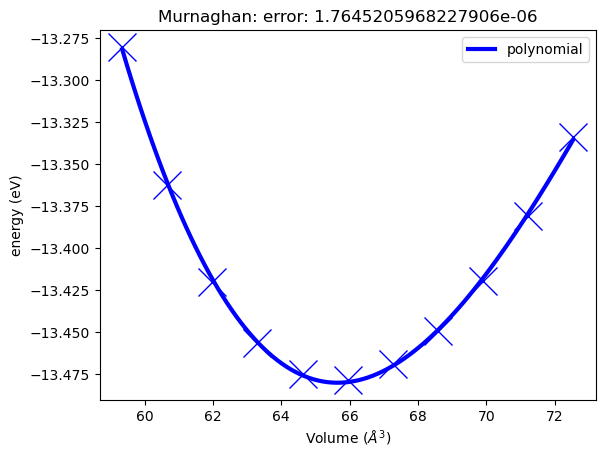

<Axes: title={'center': 'Murnaghan: error: 1.7645205968227906e-06'}, xlabel='Volume ($\\AA^3$)', ylabel='energy (eV)'>

In [15]:
murn.plot()

And take a look at the output

In [16]:
murn['output']

{'groups': ['structure'], 'nodes': ['energy', 'equilibrium_b_prime', 'equilibrium_bulk_modulus', 'equilibrium_energy', 'equilibrium_volume', 'error', 'id', 'volume']}

## <font style="font-family:roboto;color:#455e6c"> Adding strains</font>

A usual approach is to start with some prototypical structures and strain and shake them.  We can use the fcc Al we created earlier.

In [17]:
strains = np.linspace(-0.05, 0.05, 5)
strains

array([-0.05 , -0.025,  0.   ,  0.025,  0.05 ])

We will also create a `StructureStorage` which easily save these structures, and run calculations with them later.

In [18]:
from pyiron_atomistics.atomistics.structure.structurestorage import StructureStorage

In [19]:
store = StructureStorage()

In [20]:
for eps in strains:
    store.add_structure(
        structure=Al.apply_strain(eps, return_box=True),
        identifier=f'fcc_{eps}'
    )

We can also add random displacements to atom positions using the `rattle` method

In [21]:
for eps in strains:
    structure = Al.apply_strain(eps, return_box=True)
    structure.rattle(0.05)
    print('Strain', eps, 'Volume', structure.get_volume(per_atom=True))
    store.add_structure(
        structure=structure,
        identifier=f'fcc_{eps}_rattle'
    )

Strain -0.05 Volume 14.133669118000002
Strain -0.025 Volume 15.279106254750001
Strain 0.0 Volume 16.484816
Strain 0.02500000000000001 Volume 17.75234380525
Strain 0.05 Volume 19.08323512199999


## <font style="font-family:roboto;color:#455e6c"> Random crystals</font>

`pyxtal` is a [program](https://pyxtal.readthedocs.io/en/latest/) to generate random structures of a given space group and stoichiometry.
It is useful for crystal structure prediction and also for generating training structures.

In [22]:
import structuretoolkit as stk
from pyiron_atomistics import ase_to_pyiron

`structuretoolkit` is a library for structure manipulation and analysis also developed by the pyiron team.  For compatibility with a wider range of codes it operates purely on ASE `Atoms` objects, so we need to convert structures explicitely here.  In the next release of `pyiron_atomistics` you will be able to call `pr.create.structure.pyxtal` directly for a more convenient wrapper.

We usually also use random crystals generated by sampling random space groups.  One would use more spacegroups and differently sized unit cells, but we'll keep it simple here.  Details can be found in [this paper](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.107.104103).

In [23]:
groups = [1, 194, 225]

In [24]:
for i, structure in enumerate(stk.build.pyxtal(
    group=groups,
    species=['Al'],
    num_ions=[4],
    tm='metallic'
)):
    store.add_structure(
        structure=structure['atoms'],
        identifier=f'random_{i}'
    )

Spacegroups:   0%|          | 0/3 [00:00<?, ?it/s]

We can now collected a number of structures in the store.

In [25]:
store.number_of_structures

13

## <font style="font-family:roboto;color:#455e6c"> Calculating energies and forces</font>

The next step is to calculate the energies and forces

In [26]:
for i, structure in enumerate(store.iter_structures()):
    # pyiron has some opinions of what is a proper "job name" for technical reasons, but
    # you can always use this function to translate your favorite one into a "proper" one
    name = pr.create.job_name(store['identifier', i])
    job = pr.create.job.Lammps(name)
    job.potential = "2005--Mendelev-M-I--Al-Fe--LAMMPS--ipr1"
    job.structure = structure
    job.calc_static()
    job.run()

The job fcc_m0d05 was saved and received the ID: 393
The job fcc_m0d025 was saved and received the ID: 394
The job fcc_0d0 was saved and received the ID: 395
The job fcc_0d02500000000000001 was saved and received the ID: 396
The job fcc_0d05 was saved and received the ID: 397
The job fcc_m0d05_rattle was saved and received the ID: 398
The job fcc_m0d025_rattle was saved and received the ID: 399
The job fcc_0d0_rattle was saved and received the ID: 400
The job fcc_0d02500000000000001_rattle was saved and received the ID: 401
The job fcc_0d05_rattle was saved and received the ID: 402
The job random_0 was saved and received the ID: 403
The job random_1 was saved and received the ID: 404
The job random_2 was saved and received the ID: 405


Once our reference calculations are finished, we can collect the results in a container for convenience.

In [27]:
train = pr.create.job.TrainingContainer("AlLi")

We include all the jobs we did so far in the TrainingContainer

In [28]:
for job in pr.iter_jobs(hamilton='Lammps', status='finished'):
    for i in range(job.number_of_structures):
        train.include_job(job, iteration_step=i)

  0%|          | 0/24 [00:00<?, ?it/s]

"Running" the container simply saves it to disk and to our database.  It can also precompute
nearest neighbor information.

In [29]:
train.run()

The job AlLi was saved and received the ID: 406


Besides keeping everything in one place, the `TrainingContainer` also defines a number of plotting functions.

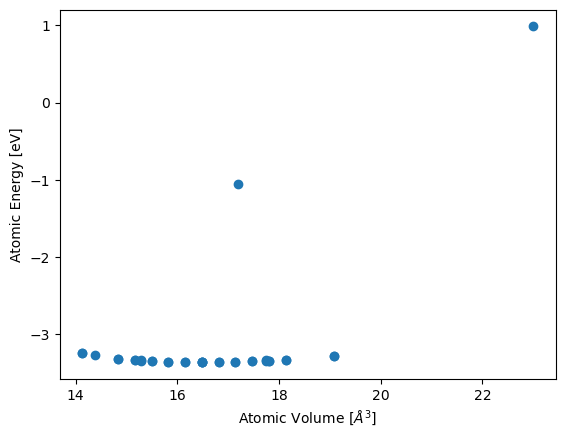

In [30]:
df = train.plot.energy_volume()

Text(0, 0.5, 'Energy [eV/atom]')

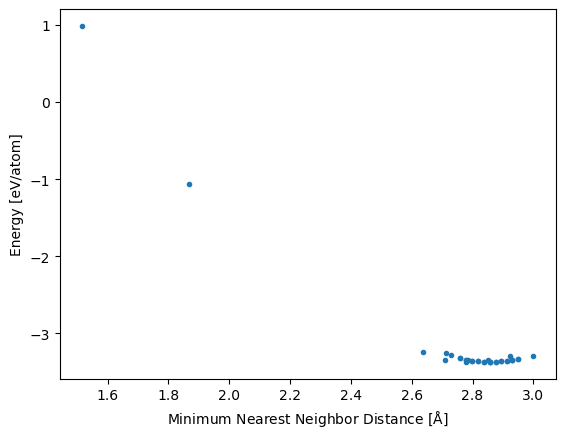

In [31]:
train.plot.energy_distance()
plt.xlabel(r'Minimum Nearest Neighbor Distance [$\mathrm{\AA}$]')
plt.ylabel('Energy [eV/atom]')

For fitting potentials within pyiron you can use the container as is, but if you have external tools, you can
export the data into a table.

In [32]:
train.to_pandas()

,name,atoms,energy,forces,stress,number_of_atoms
0,murnaghan_0_9,"[Atom('Al', [0.0, 0.0, 0.0], index=0), Atom('Al', [0.0, 1.9502885569035455, 1.9502885569035457], index=1), Atom('Al', [1.9502885569033719, 1.1942073193127126e-16, 1.9502885569035457], index=2), At...",-13.280098,"[[5.5511151231257796e-17, 2.7115698575386195e-11, 2.71157402087496e-11], [0.0, -2.7115712453173996e-11, -2.7115684697598397e-11], [-3.816391647148979e-17, 2.7115781842113093e-11, -2.71157506170904...","[11.712128754699998, 11.712128754895097, 11.712128754895097, 9.419605003210391e-16, 2.1221576168875112e-15, 1.3306762172773813e-15]",4
1,murnaghan_0_9,"[Atom('Al', [0.0, 1.7737771094289194e-12, 1.7737771094289196e-12], index=0), Atom('Al', [0.0, 1.9502885569017743, 1.9502885569017745], index=1), Atom('Al', [1.9502885569033719, 1.7738965301608507e...",-13.280098,"[[-5.5511151231257796e-17, 2.6922908347159995e-15, 2.8310687127941504e-15], [2.7755575615628898e-17, -2.6506574712925597e-15, -2.84494650060196e-15], [-3.816391647148979e-17, 3.52495810318487e-15,...","[11.712128754699998, 11.712128754895097, 11.712128754895097, -6.17668877427894e-15, 9.981603630033035e-16, 1.3213095734950124e-15]",4
2,murnaghan_0_92,"[Atom('Al', [0.0, 0.0, 0.0], index=0), Atom('Al', [0.0, 1.9646294289620627, 1.964629428962063], index=1), Atom('Al', [1.964629428962089, 1.2029885708445572e-16, 1.964629428962063], index=2), Atom(...",-13.362588,"[[7.466249840604181e-15, 8.947557278427001e-11, 8.947253354874009e-11], [6.5503158452884204e-15, -8.947889651445001e-11, -8.94726376321486e-11], [-6.501743587961071e-15, 8.94759648317756e-11, -8.9...","[8.41591955239021, 8.41591955305308, 8.41591955305308, 3.832340082259694e-15, 6.06956658001099e-16, -2.7787796353186547e-15]",4
3,murnaghan_0_92,"[Atom('Al', [0.0, 6.253870198020177e-12, 6.253870198020177e-12], index=0), Atom('Al', [0.0, 1.9646294289562551, 1.9646294289562554], index=1), Atom('Al', [1.964629428962089, 6.2539904968772615e-12...",-13.362588,"[[7.771561172376101e-16, 5.41233724504764e-16, -2.0122792321330994e-16], [9.71445146547012e-16, -1.62370117351429e-15, -3.9939162782502336e-32], [-8.39606162372775e-16, -1.8041124150158804e-16, -5...","[8.41591955239025, 8.4159195530531, 8.41591955305311, -3.223186158217195e-15, 1.4682806406047737e-15, 8.528388391627427e-15]",4
4,murnaghan_0_94,"[Atom('Al', [0.0, 0.0, 0.0], index=0), Atom('Al', [0.0, 1.978763939605398, 1.9787639396053982], index=1), Atom('Al', [1.9787639396054337, 1.2116434624530005e-16, 1.9787639396053982], index=2), Ato...",-13.420059,"[[0.0, 3.717292446081539e-11, 3.71729452774971e-11], [-6.938893903907228e-18, -3.717263302727149e-11, -3.71728342551947e-11], [-1.3877787807814497e-17, 3.717290711358069e-11, -3.717303201367089e-1...","[5.627175591864479, 5.6271755921245985, 5.627175592124589, -3.209352537114582e-17, 3.714693184285559e-16, -2.0248672610922845e-16]",4
5,murnaghan_0_94,"[Atom('Al', [0.0, 2.6995129786882887e-12, 2.699512978688289e-12], index=0), Atom('Al', [0.0, 1.978763939602699, 1.9787639396026993], index=1), Atom('Al', [1.9787639396054337, 2.699634143034534e-12...",-13.420059,"[[0.0, -2.0816681711721697e-17, -6.93889390390723e-18], [6.938893903907228e-18, -1.3877787807814497e-17, -2.7755575615628898e-17], [2.0816681711721697e-17, 1.2746541313564613e-33, -2.0816681711721...","[5.627175591864448, 5.627175592124568, 5.627175592124568, 9.274892365904603e-16, 2.279803072941086e-16, 2.190122440982056e-16]",4
6,murnaghan_0_96,"[Atom('Al', [0.0, 0.0, 0.0], index=0), Atom('Al', [0.0, 1.9926993560590622, 1.9926993560590625], index=1), Atom('Al', [1.9926993560590198, 1.2201764440303352e-16, 1.9926993560590625], index=2), At...",-13.456412,"[[2.42861286636753e-17, 5.7456789326337785e-11, 5.7454187241123794e-11], [-5.204170427930419e-18, -5.7458988955705285e-11, -5.74541247910787e-11], [6.938893903907228e-18, 5.745563053105579e-11, -5...","[3.2720639786780197, 3.2720639790484696, 3.2720639790484696, 1.4341187446430929e-15, -1.9918976493921736e-16, 1.9816082676816464e-16]

## <font style="font-family:roboto;color:#455e6c"> Fitting an ACE potential </font>

Now that we have looked at how we create datasets for fitting, we can actually go ahead and fit an ACE potential. Note that we used an empirical potential instead of DFT before. For the fitting, we provide a very small [Al dataset](https://arxiv.org/abs/2403.05724) that can be used. This dataset is in the form of a packed pyiron project. We start by extracting it first. 

In [53]:
pr = Project('fitting')

We will extract the 'dataset.tar.gz' file into this project

In [54]:
pr.unpack('dataset')

Now we create a job for fitting

In [56]:
job = pr.create.job.PacemakerJob("pacemaker_job")

Now we add the training set we created above to this fitting job

In [57]:
training_data = pr.load('Al_dataset')

DEBUG:pyiron_log:sql_query: {'job': 'Al_dataset', 'project': '/mnt/c/Users/menon/Documents/repos/projects-workshops/dpg_tutorial_2024/tutorial/fitting/'}
DEBUG:pyiron_log:sql_query: {'job': 'Al_dataset', 'project': '/mnt/c/Users/menon/Documents/repos/projects-workshops/dpg_tutorial_2024/tutorial/fitting/%'}


In [58]:
job.add_training_data(training_data)

We can now take a look at the different potential settings

In [59]:
job.input

,Parameter,Value,Comment
0,cutoff,7.0,
1,metadata,{'comment': 'pyiron-generated fitting job'},
2,data,{},
3,potential,"{'elements': [], 'bonds': {'ALL': {'radbase': 'SBessel', 'rcut': 7.0, 'dcut': 0.01, 'radparameters': [5.25]}}, 'embeddings': {'ALL': {'fs_parameters': [1, 1, 1, 0.5], 'ndensity': 2, 'npot': 'Finni...",
4,fit,"{'loss': {'L1_coeffs': 1e-08, 'L2_coeffs': 1e-08, 'kappa': 0.3, 'w0_rad': 0, 'w1_rad': 0, 'w2_rad': 0}, 'maxiter': 1000, 'optimizer': 'BFGS', 'fit_cycles': 1}",
5,backend,"{'batch_size': 100, 'display_step': 50, 'evaluator': 'tensorpot'}",


The job starts with a robust set of default input parameters. Any input quantity can of course be reset. For example, an important setting is the cutoff distance. We change it to 6.0

In [60]:
job.cutoff=6.0

In general a (P)ACE potential specification consists of three parts:

#### 1. Embeddings
 i.e. how atomic energy $E_i$ depends on ACE properties/densities $\varphi$. Linear expansion $E_i = \varphi$ is the trivial. Non-linear expansion, i.e. those, containing square root, gives more flexiblity and accuracy of final potential

Embeddings for `ALL` species: 
- non-linear `FinnisSinclairShiftedScaled`
- 2 densities
- fs_parameters': [1, 1, 1, 0.5]:
$$E_i = 1.0 * \varphi(1)^1 + 1.0 * \varphi(2)^{0.5} = \varphi^{(1)} + \sqrt{\varphi^{(2)}} $$

In [61]:
job.input["potential"]["embeddings"]

{'ALL': {'fs_parameters': [1, 1, 1, 0.5],
  'ndensity': 2,
  'npot': 'FinnisSinclairShiftedScaled'}}

#### 2. Radial functions

Radial functions are orthogonal polynoms example:
* (a) Exponentially-scaled Chebyshev polynomials (λ = 5.25)
* (b) Power-law scaled Chebyshev polynomials (λ = 2.0)
* (c) Simplified spherical Bessel functions

<img src="img/radial-functions-low.png" width="300">

Radial functions specification for `ALL` species pairs (i.e. Al-Al, Al-Li, Li-Al, Li-Li):

* based on the Simplified Bessel
* cutoff $r_c=6.0$

In [62]:
job.input["potential"]["bonds"]

{'ALL': {'radbase': 'SBessel',
  'rcut': 6.0,
  'dcut': 0.01,
  'radparameters': [5.25]}}

#### 3. B-basis functions

B-basis functions  for `ALL` species type interactions, i.e. Al-Al block:
* maximum order = 4, i.e. body-order 5 (1 central atom + 4 neighbour  densities)
* nradmax_by_orders: 15, 3, 2, 1
* lmax_by_orders: 0, 3, 2, 1

In [63]:
job.input["potential"]["functions"]

{'ALL': {'nradmax_by_orders': [15, 3, 2, 1], 'lmax_by_orders': [0, 3, 2, 1]}}

We will reduce the basis size for demonstartion purposes

In [64]:
job.input["potential"]["functions"]={'ALL': {'nradmax_by_orders': [15, 3, 2], 'lmax_by_orders': [0, 2, 1]}}

Loss function specification

<img src="img/loss-func.png" width="300">

<img src="img/loss-reg.png" width="300">

In [65]:
job.input["fit"]['loss']

{'L1_coeffs': 1e-08,
 'L2_coeffs': 1e-08,
 'kappa': 0.3,
 'w0_rad': 0,
 'w1_rad': 0,
 'w2_rad': 0}

#### Weighting

Energy-based weighting puts more "accent" onto the low energy-lying structures, close to convex hull

In [66]:
job.input["fit"]['weighting'] =  {
        ## weights for the structures energies/forces are associated according to the distance to E_min:
        ## convex hull ( energy: convex_hull) or minimal energy per atom (energy: cohesive)
        "type": "EnergyBasedWeightingPolicy",
        ## number of structures to randomly select from the initial dataset
        "nfit": 10000,         
        ## only the structures with energy up to E_min + DEup will be selected
        "DEup": 10.0,  ## eV, upper energy range (E_min + DElow, E_min + DEup)        
        ## only the structures with maximal force on atom  up to DFup will be selected
        "DFup": 50.0, ## eV/A
        ## lower energy range (E_min, E_min + DElow)
        "DElow": 1.0,  ## eV
        ## delta_E  shift for weights, see paper
        "DE": 1.0,
        ## delta_F  shift for weights, see paper
        "DF": 1.0,
        ## 0<wlow<1 or None: if provided, the renormalization weights of the structures on lower energy range (see DElow)
        "wlow": 0.95,        
        ##  "convex_hull" or "cohesive" : method to compute the E_min
        "energy": "convex_hull",        
        ## structures types: all (default), bulk or cluster
        "reftype": "all",        
        ## random number seed
        "seed": 42 
}

Maximum number of iterations by optimizer (`SciPy.minimize.BFGS`). Typical values are ~1000-1500, but we chose small value for demonstration purposes only

In [67]:
job.input["fit"]["maxiter"]=100

For more details about these and other settings please refer to [official documentation](https://pacemaker.readthedocs.io/en/latest/pacemaker/inputfile/)

Now we can run the fit

In [68]:
job.run()

INFO:pyiron_log:run job: pacemaker_job id: None, status: initialized
INFO:pyiron_log:run job: pacemaker_job id: 423, status: created
INFO:pyiron_log:job: pacemaker_job id: 423, status: submitted, run job (modal)


Set automatically determined list of elements: ['Al']
The job pacemaker_job was saved and received the ID: 423


INFO:pyiron_log:job: pacemaker_job id: 423, status: running, output: /home/srmnitc/miniconda3/envs/workshop-ml4ms-3/bin/pacemaker:8: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources
2024/05/07 13:26:53 I - Redirecting log into file log.txt
2024/05/07 13:26:53 I - Start pacemaker
2024/05/07 13:26:53 I - Hostname: cmleo26
2024/05/07 13:26:53 I - Username: srmnitc
2024/05/07 13:26:53 I - pacemaker/pyace version: 0.2.7+158.g636a42a
2024/05/07 13:26:53 I - ace_evaluator   version: 2023.11.25
2024/05/07 13:26:53 I - Loading input.yaml... 
2024/05/07 13:26:53 W - No 'seed' provided in YAML file, default value seed = 42 will be used.
2024/05/07 13:26:53 I - Set numpy random seed to 42
2024/05/07 13:26:53 I - Target potential shape constructed from dictionary, it contains 43 functions
2024/05/07 13:26:56 I - tensorpot_version: 0+untagged.1.g8776209
2024/05/07 13:26:56 I - User name automatically identif

Take a look at the fitting results

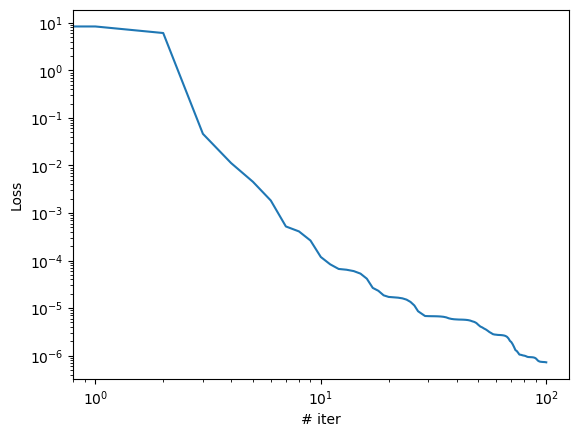

In [69]:
plt.plot(job["output/log/loss"])
plt.xlabel("# iter")
plt.ylabel("Loss")
plt.loglog();

plot RMSE values of energy per atom

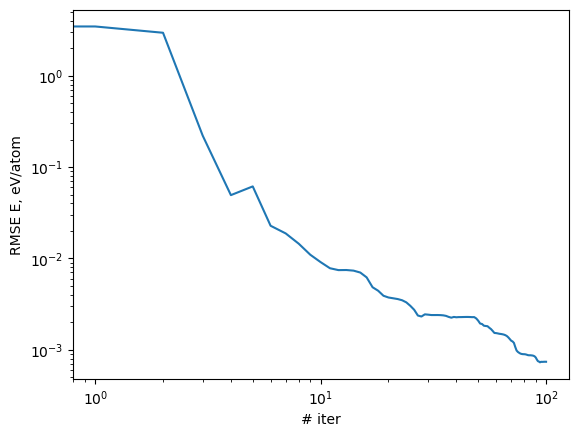

In [70]:
plt.plot(job["output/log/rmse_epa"])
plt.xlabel("# iter")
plt.ylabel("RMSE E, eV/atom")
plt.loglog();

As we see, the really small potential we fit, has already reached meV accuracy!

plot force component RMSE

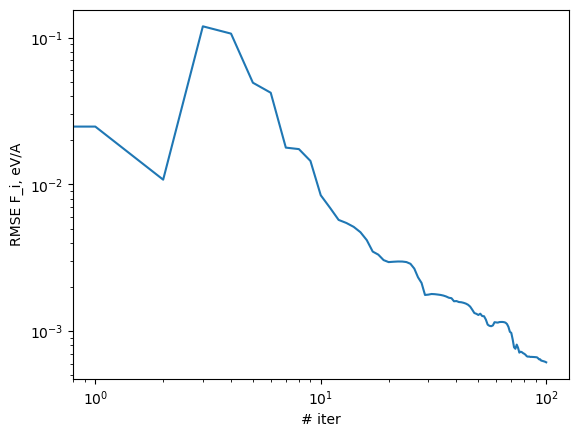

In [71]:
plt.plot(job["output/log/rmse_f_comp"])
plt.xlabel("# iter")
plt.ylabel("RMSE F_i, eV/A")
plt.loglog();

load DataFrame with predictions of energy

In [72]:
ref_df = job.training_data

In [73]:
pred_df = job.predicted_data

Text(0, 0.5, 'ACE E, eV/atom')

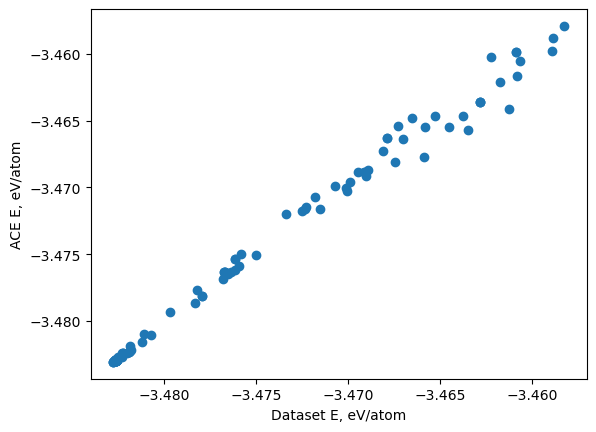

In [74]:
plt.scatter(pred_df["energy_per_atom_true"],pred_df["energy_per_atom"])
plt.xlabel("Dataset E, eV/atom")
plt.ylabel("ACE E, eV/atom")

and forces

Text(0, 0.5, 'ACE F_i, eV/A')

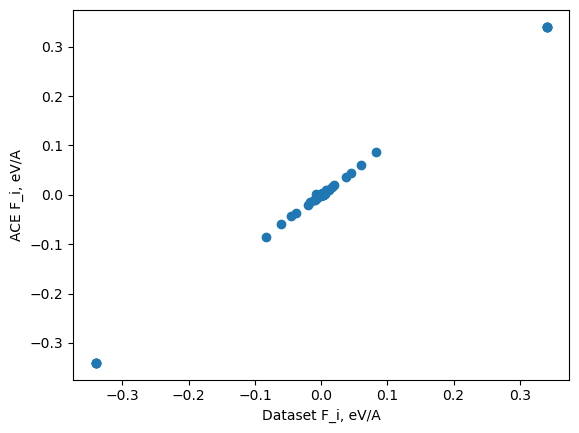

In [75]:
plt.scatter(ref_df["forces"],pred_df["forces"])
plt.xlabel("Dataset F_i, eV/A")
plt.ylabel("ACE F_i, eV/A")

Check more in `job.working_directory`/report folder

In [76]:
! ls {job.working_directory}/report

train_E-dE-dist.png  train_EF-pairplots.png  train_Fi-dFi-dist.png
train_E-dE-nn.png    train_F-dF-dist.png


---

## <font style="font-family:roboto;color:#455e6c"> Bonus: Scaling structures</font>  

Another approach used is scaling the structures. We start by creating a bulk fcc again.

In [15]:
Al = pr.create.structure.bulk('Al', cubic=True, a=4.04)

We now scale the structure such that minimum nearest neighbor distance is varied from 2 to 6.5 Å in 0.5 intervals. We will also create a `StructureStorage` which easily save these structures, and run calculations with them later.

In [16]:
store = StructureStorage()

We start by getting the minimum nearest neighbor distance

In [17]:
distances = Al.get_all_distances(mic=True).flatten()
min_distance = np.min(distances[np.nonzero(distances)])
min_distance

2.856711395993652

The range of distances needed, and convert them to fractions

In [18]:
d_arr = np.arange(2, 7, 0.5)
scale = d_arr/np.min(distances[np.nonzero(distances)])

Now for each scaling, create a structure and store it

In [19]:
for s in scale:
    struct = Al.copy()
    struct.apply_strain(s)
    store.add_structure(struct, identifier=f'fcc_nnscale_{s}')

Note that this procedure has to be repeated for other bulk structures of interest.

## <font style="font-family:roboto;color:#455e6c"> Bonus: Structures from Materials Project</font>  

For binary AlLi structures, we queried them from materials project. This can be done with pyiron. Note that you have to provide a [Materials Project API key](https://next-gen.materialsproject.org/api#api-key) for this functionality.

In [20]:
api_key=''

We can query structures that lie on the convex hull

In [21]:
structures = pr.create.structure.materialsproject.search(['Al-Li'], is_stable=True, api_key=api_key)

/home/menon/miniconda3/envs/potentials_v0.0.2/lib/python3.11/site-packages/mp_api/client/mprester.py:227: UserWarning: mpcontribs-client not installed. Install the package to query MPContribs data, or construct pourbaix diagrams: 'pip install mpcontribs-client'
  warnings.warn(


Retrieving SummaryDoc documents:   0%|          | 0/4 [00:00<?, ?it/s]

We add these structures to the store

In [22]:
for structure in structures:
    store.add_structure(structure, identifier=structure.get_chemical_formula())

Note that you can also visualise the structures.

In [23]:
structures.get_structure(frame=3).plot3d()

NGLWidget()

We need to relax these structure, but also perfrom EV curves, and scaling of the nearest neighbor distance as before. This is skipped for now.

## <font style="font-family:roboto;color:#455e6c"> Bonus: How does an actual potential file look like ? </font> 

`output_potential.yaml`:

```yaml
species:
    # Pure Al interaction block
  - speciesblock: Al
    radbase: SBessel
    radcoefficients: [[[1.995274603767268, -1.1940566258712266,...]]]
  
    nbody:
      # first order/ two-body functions = pair functions
      - {type: Al Al, nr: [1], nl: [0], c: [2.0970219095074687, -3.9539202281610351]}
      - {type: Al Al, nr: [2], nl: [0], c: [-1.8968648691718397, -2.3146574133175974]}
      - {type: Al Al, nr: [3], nl: [0], c: [1.3504952496800906, 1.5291190439028692]}
      - {type: Al Al, nr: [4], nl: [0], c: [0.040517989827027742, 0.11933504671036224]}
      ...
      # second order/ three-body functions 
      - {type: Al Al Al, nr: [1, 1], nl: [0, 0], c: [0.57788490809100468, -1.8642896163994958]}
      - {type: Al Al Al, nr: [1, 1], nl: [1, 1], c: [-1.0126646532267587, -1.2336078784112348]}
      - {type: Al Al Al, nr: [1, 1], nl: [2, 2], c: [-0.19324470046809467, 0.63954472122968498]}
      - {type: Al Al Al, nr: [1, 1], nl: [3, 3], c: [-0.22018334529075642, 0.32822679746839439]}
      ...
      # fifth order/ six-body functions 
      - {type: Al Al Al Al Al Al, nr: [1, 1, 1, 1, 1], nl: [0, 0, 0, 0, 0], lint: [0, 0, 0], c: [-0.71...]}
  
  
  # binary Al-Li interaction block    
  - speciesblock: Al Li      
     ...
     nbody:
      - {type: Al Li, nr: [1], nl: [0], c: [0.91843424537280882, -2.4170371138562308]}
      - {type: Al Li, nr: [2], nl: [0], c: [-0.88380210517336399, -0.97055273167339651]}
      ...
      - {type: Al Al Al Li Li, nr: [1, 1, 1, 1], nl: [1, 1, 0, 0], lint: [0, 0], c: [-0.0050,...]}
      ...
  # Pure Li interaction block      
  - speciesblock: Li
      nbody:
       ...
       - {type: Li Li Li, nr: [4, 4], nl: [3, 3], c: [-0.0059111333449957159, 0.035]}
       - {type: Li Li Li Li, nr: [1, 1, 1], nl: [0, 0, 0], lint: [0], c: [0.210,...]}
       ...
  # binary Al-Li interaction block    
  - speciesblock: Li Al
      nbody:
       ...
       - {type: Li Al Al, nr: [4, 4], nl: [3, 3], c: [0.014680736321211739, -0.030618474343919122]}
       - {type: Li Al Li, nr: [1, 1], nl: [0, 0], c: [-0.22827705573988896, 0.28367909613209036]}
       ...
  
```

`output_potential.yaml` is in B-basis form. For efficient LAMMPS implementaion it should be converted to so-called `C-tilde` form.  This is already done by `pyiron`, but it could be also done manually by `pace_yaml2yace` utility. Check [here](https://pacemaker.readthedocs.io/en/latest/pacemaker/quickstart/#lammps) for more details

## <font style="font-family:roboto;color:#455e6c"> Further reading </font> 

* [Documentation](https://pacemaker.readthedocs.io/en/latest/)
* [`pacemaker` repository](https://github.com/ICAMS/python-ace)
* [Bochkarev, A., Lysogorskiy, Y., Menon, S., Qamar, M., Mrovec, M. and Drautz, R. Efficient parametrization of the atomic cluster expansion. Physical Review Materials 6(1) 013804 (2022)](https://journals.aps.org/prmaterials/abstract/10.1103/PhysRevMaterials.6.013804)
* [Lysogorskiy, Y., Oord, C. v. d., Bochkarev, A., Menon, S., Rinaldi, M., Hammerschmidt, T., Mrovec, M., Thompson, A., Csányi, G., Ortner, C. and  Drautz, R. Performant implementation of the atomic cluster expansion (PACE) and application to copper and silicon. npj Computational Materials 7(1), 1-12 (2021)](https://www.nature.com/articles/s41524-021-00559-9)
* [Drautz, R. Atomic cluster expansion for accurate and transferable interatomic potentials. Physical Review B, 99(1), 014104 (2019)](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.99.014104)

## <font style="font-family:roboto;color:#455e6c"> Software used in this notebook </font>  

- [pacemaker](https://github.com/ICAMS/python-ace)
- [pyiron_atomistics](https://github.com/pyiron/pyiron_atomistics)
- [LAMMPS](https://www.lammps.org/)
- [pyXtal](https://pyxtal.readthedocs.io/en/latest/)